In [10]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

import math
import torch
import torch_geometric as pyg
import numpy as np
from models.LASE_unshared_normalized import LASE 
from models.RDPG_GD import RDPG_GD_Armijo, coordinate_descent
from models.SVD_truncate import embed_scipy
from models.bigbird_attention import big_bird_attention
from graspologic.embed import AdjacencySpectralEmbed 
from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph, erdos_renyi_graph
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numpy import random
import time
from networkx import watts_strogatz_graph
from torch_geometric.utils.convert import from_networkx
from training.get_init import get_x_init
from scipy.stats import sem
import timeit

In [75]:
torch.manual_seed(42)
d = 5
gd_steps = 5
device = 'cuda'

p = [
     [0.9, 0.2, 0.1],
     [0.2, 0.6, 0.2],
     [0.1, 0.2, 0.7]
]

num_nodes = 240
nodes = [num_nodes*2*i for i in range(1,11)]

n = [[120*2*i, 80*2*i, 40*2*i] for i in range(1,11)]


# Performance comparison

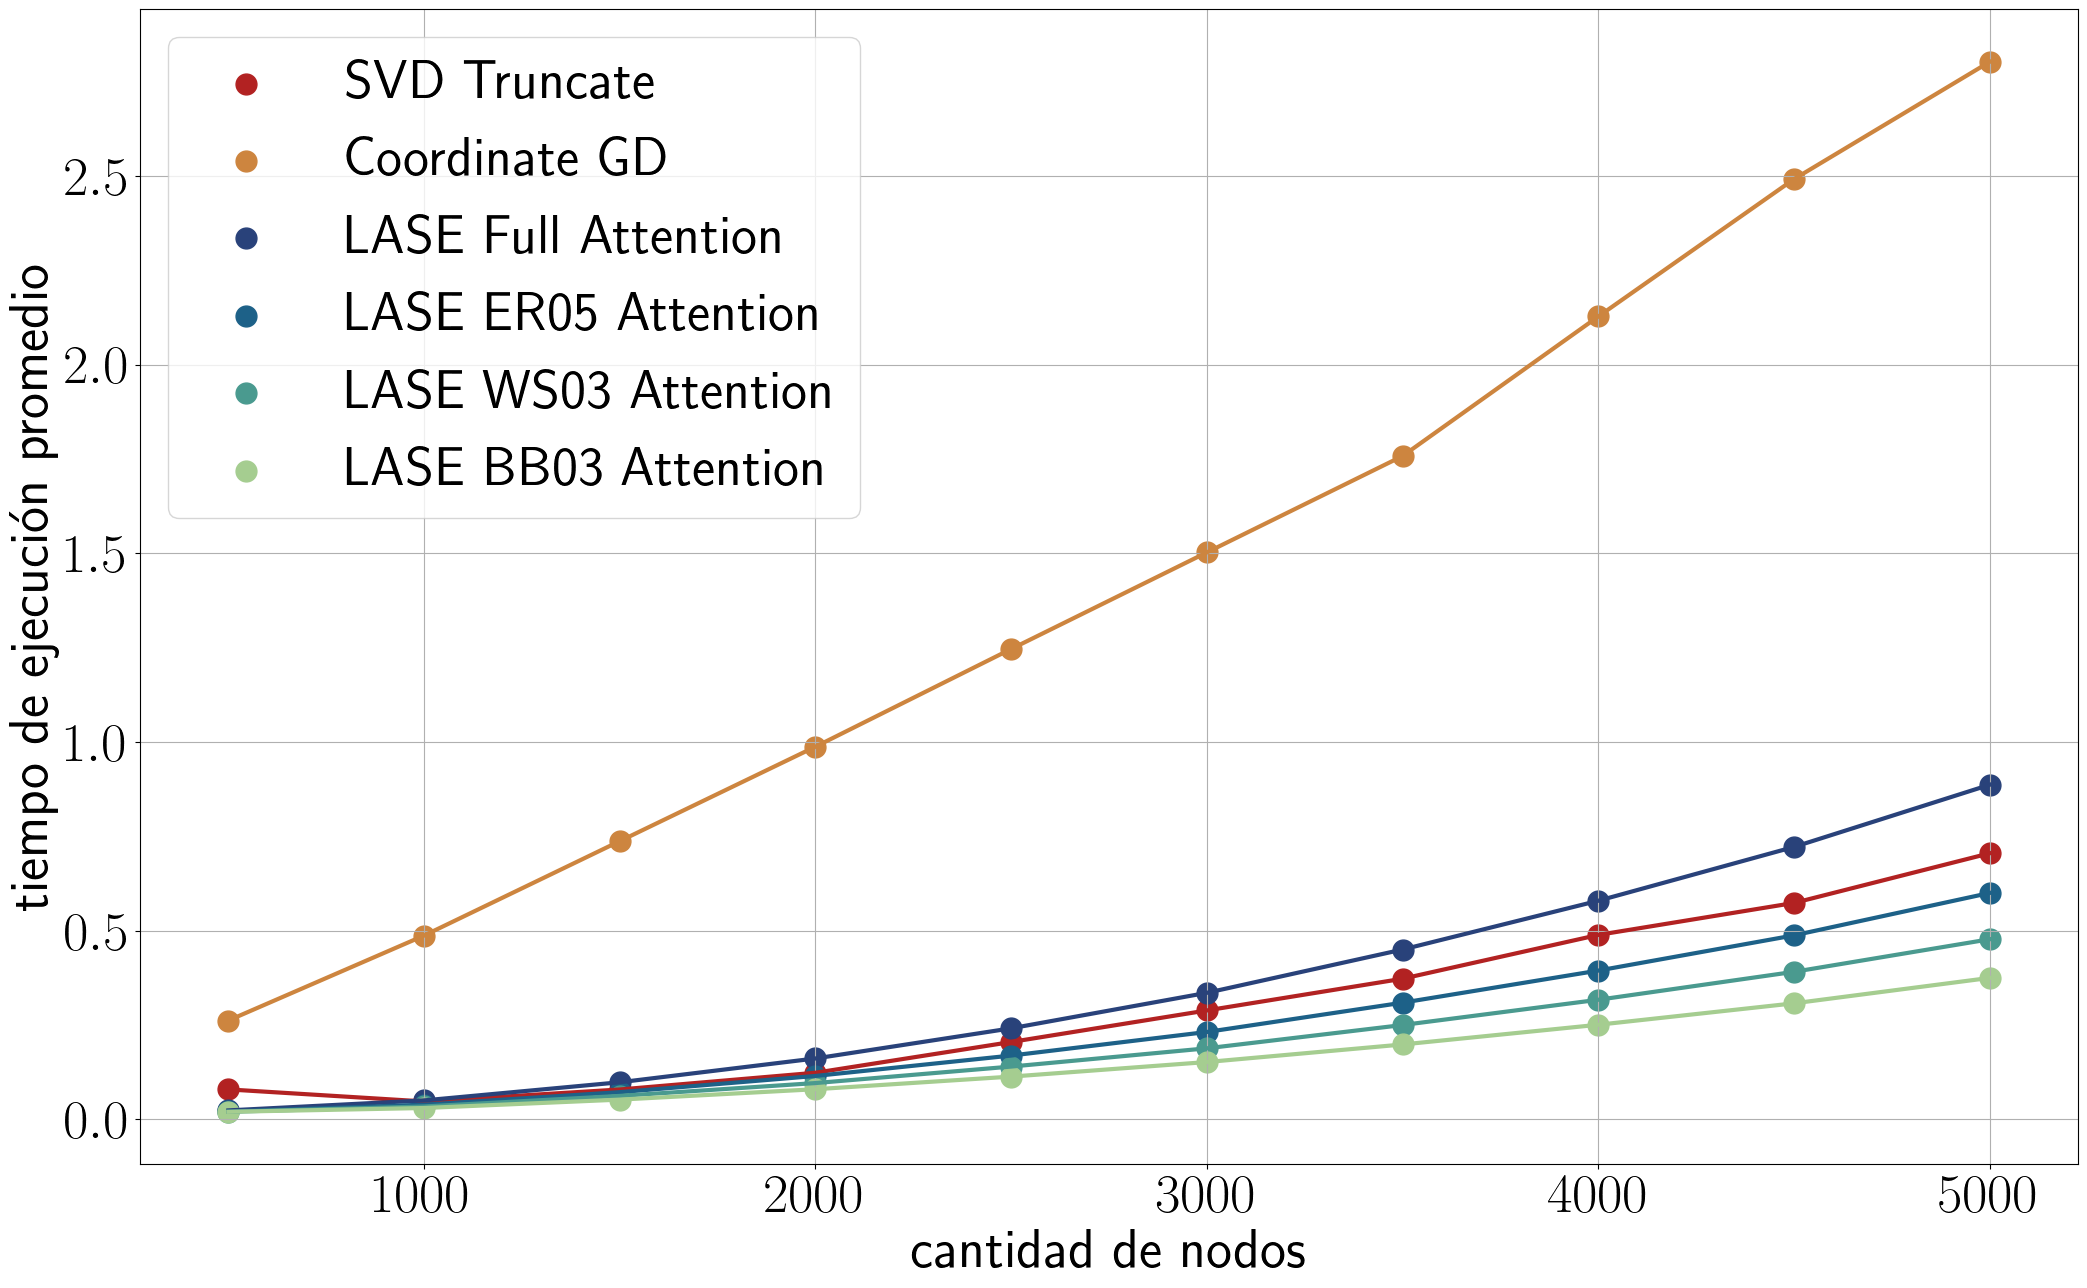

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 40
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True

# Assuming 'nodes' and the 'exec_time' arrays are already defined
# Define the colormap
crest_cmap = cm.get_cmap('crest')

# Generate colors from the colormap
colors = [crest_cmap(i) for i in np.linspace(0, 2, 12)]  # Generate 8 colors from the crest colormap

plt.figure(figsize =(25,15))
# Adjust each plot to use a color from the generated list
plt.scatter(nodes, svd_exec_time[:,0], c='firebrick', label='SVD Truncate')
plt.plot(nodes, svd_exec_time[:,0], c='firebrick')
plt.scatter(nodes, cgd_exec_time[:,0], c='peru', label='Coordinate GD')
plt.plot(nodes, cgd_exec_time[:,0], c='peru')

plt.scatter(nodes, lase_full_exec_time[:,0], c=colors[5], label='LASE Full Attention')
plt.plot(nodes, lase_full_exec_time[:,0], c=colors[5])
plt.scatter(nodes, lase_ER05_exec_time[:,0], c=colors[4], label='LASE ER05 Attention')
plt.plot(nodes, lase_ER05_exec_time[:,0], c=colors[4])
plt.scatter(nodes, lase_WS03_exec_time[:,0], c=colors[2], label='LASE WS03 Attention')
plt.plot(nodes, lase_WS03_exec_time[:,0], c=colors[2])
# plt.scatter(nodes, lase_WS01_exec_time[:,0], c=colors[4], label='LASE WS01 Attention')
# plt.plot(nodes, lase_WS01_exec_time[:,0], c=colors[4])
plt.scatter(nodes, lase_BB03_exec_time[:,0], c=colors[0], label='LASE BB03 Attention')
plt.plot(nodes, lase_BB03_exec_time[:,0], c=colors[0])
# plt.scatter(nodes, lase_BB01_exec_time[:,0], c=colors[0], label='LASE BB01 Attention')
# plt.plot(nodes, lase_BB01_exec_time[:,0], c=colors[0])
plt.xlabel('cantidad de nodos')
plt.ylabel('tiempo de ejecución promedio')
plt.legend()
plt.show()


In [56]:
print(f'{nodes[0]}  _ {svd_exec_time[0,0]:.2f} _ {svd_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {svd_exec_time[2,0]:.2f} _ {svd_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {svd_exec_time[4,0]:.2f} _ {svd_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {svd_exec_time[6,0]:.2f} _ {svd_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {svd_exec_time[9,0]:.2f} _ {svd_exec_time[9,1]:.2f} ')

480  _ 0.08 _ 0.01 
1440 _ 0.08 _ 0.01 
2400 _ 0.21 _ 0.01 
3360 _ 0.37 _ 0.00 
4800 _ 0.71 _ 0.01 


In [57]:
print(f'{nodes[0]}  _ {cgd_exec_time[0,0]:.2f} _ {cgd_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {cgd_exec_time[2,0]:.2f} _ {cgd_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {cgd_exec_time[4,0]:.2f} _ {cgd_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {cgd_exec_time[6,0]:.2f} _ {cgd_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {cgd_exec_time[9,0]:.2f} _ {cgd_exec_time[9,1]:.2f} ')

480  _ 0.26 _ 0.02 
1440 _ 0.74 _ 0.00 
2400 _ 1.25 _ 0.00 
3360 _ 1.76 _ 0.00 
4800 _ 2.80 _ 0.00 


In [58]:
print(f'{nodes[0]}  _ {lase_full_exec_time[0,0]:.2f} _ {lase_full_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_full_exec_time[2,0]:.2f} _ {lase_full_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_full_exec_time[4,0]:.2f} _ {lase_full_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_full_exec_time[6,0]:.2f} _ {lase_full_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_full_exec_time[9,0]:.2f} _ {lase_full_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.00 
1440 _ 0.10 _ 0.00 
2400 _ 0.24 _ 0.00 
3360 _ 0.45 _ 0.00 
4800 _ 0.89 _ 0.00 


In [59]:
print(f'{nodes[0]}  _ {lase_ER05_exec_time[0,0]:.2f} _ {lase_ER05_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_ER05_exec_time[2,0]:.2f} _ {lase_ER05_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_ER05_exec_time[4,0]:.2f} _ {lase_ER05_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_ER05_exec_time[6,0]:.2f} _ {lase_ER05_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_ER05_exec_time[9,0]:.2f} _ {lase_ER05_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.00 
1440 _ 0.07 _ 0.00 
2400 _ 0.17 _ 0.00 
3360 _ 0.31 _ 0.00 
4800 _ 0.60 _ 0.00 


In [60]:
print(f'{nodes[0]}  _ {lase_WS03_exec_time[0,0]:.2f} _ {lase_WS03_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_WS03_exec_time[2,0]:.2f} _ {lase_WS03_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_WS03_exec_time[4,0]:.2f} _ {lase_WS03_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_WS03_exec_time[6,0]:.2f} _ {lase_WS03_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_WS03_exec_time[9,0]:.2f} _ {lase_WS03_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.01 
1440 _ 0.06 _ 0.00 
2400 _ 0.14 _ 0.00 
3360 _ 0.25 _ 0.00 
4800 _ 0.48 _ 0.00 


In [61]:
print(f'{nodes[0]}  _ {lase_BB03_exec_time[0,0]:.2f} _ {lase_BB03_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_BB03_exec_time[2,0]:.2f} _ {lase_BB03_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_BB03_exec_time[4,0]:.2f} _ {lase_BB03_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_BB03_exec_time[6,0]:.2f} _ {lase_BB03_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_BB03_exec_time[9,0]:.2f} _ {lase_BB03_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.01 
1440 _ 0.05 _ 0.00 
2400 _ 0.11 _ 0.00 
3360 _ 0.20 _ 0.00 
4800 _ 0.37 _ 0.00 


In [74]:
lase_full_exec_time[9,0]/lase_BB03_exec_time[9,0]

2.3648283365565232

In [71]:
lase_full_exec_time[9,0]/lase_BB03_exec_time[9,0]

2.3648283365565232

In [72]:
cgd_exec_time[9,0]/lase_BB03_exec_time[9,0]

7.47402257555686

In [73]:
svd_exec_time[9,0] / lase_BB03_exec_time[9,0]

1.880658781854442